<a href="https://colab.research.google.com/github/RafsanJany-44/ARC/blob/master/PK_PD_HAL_DL_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available: 1


In [3]:
import pandas as pd


Patients_train_path = "/content/drive/MyDrive/Iqram Sir/PK_PD/Patients_train.csv"
Patients_test_path = "/content/drive/MyDrive/Iqram Sir/PK_PD/Patients_test.csv"


Patients_train = pd.read_csv(Patients_train_path, index_col=0)
Patients_test = pd.read_csv(Patients_test_path, index_col=0)

# %% Undersample data

step = 60  # Undersampling step


Patients_test_full = Patients_test.copy()

Patients_train_BIS = Patients_train[Patients_train['full_BIS'] == 0]
Patients_test_BIS = Patients_test[Patients_test['full_BIS'] == 0]
Patients_train_MAP = Patients_train[Patients_train['full_MAP'] == 0]
Patients_test_MAP = Patients_test[Patients_test['full_MAP'] == 0]

Patients_train_BIS = Patients_train_BIS[::step]
Patients_test_BIS = Patients_test_BIS[::step]
Patients_train_MAP = Patients_train_MAP[::step]
Patients_test_MAP = Patients_test_MAP[::step]



feature = 'All'
cov = ['age', 'sex', 'height', 'weight']
Ce_bis_eleveld = ['Ce_Prop_Eleveld', 'Ce_Rem_Eleveld']
Ce_map_eleveld = ['Ce_Prop_MAP_Eleveld', 'Ce_Rem_MAP_Eleveld']
Cplasma_eleveld = ['Cp_Prop_Eleveld', 'Cp_Rem_Eleveld']


# feat_A/ input features
if feature == 'All':
    X_col = cov + ['bmi', 'lbm', 'mean_HR'] + Ce_map_eleveld + Ce_bis_eleveld + Cplasma_eleveld
elif feature == '-bmi':
    X_col = cov + ['lbm', 'MAP_base_case', 'mean_HR'] + Ce_bis_eleveld + Ce_map_eleveld + Cplasma_eleveld
elif feature == '-lbm':
    X_col = cov + ['bmi', 'MAP_base_case', 'mean_HR'] + Ce_bis_eleveld + Ce_map_eleveld + Cplasma_eleveld
elif feature == '-map':
    X_col = cov + ['bmi', 'lbm', 'mean_HR'] + Ce_bis_eleveld + Ce_map_eleveld + Cplasma_eleveld
elif feature == '-hr':
    X_col = cov + ['bmi', 'lbm', 'MAP_base_case'] + Ce_bis_eleveld + Ce_map_eleveld + Cplasma_eleveld
elif feature == '-Cplasma':
    X_col = cov + ['bmi', 'lbm', 'MAP_base_case', 'mean_HR'] + Ce_bis_eleveld + Ce_map_eleveld
elif feature == '-Cmap':
    X_col = cov + ['bmi', 'lbm', 'MAP_base_case', 'mean_HR'] + Ce_bis_eleveld + Cplasma_eleveld
elif feature == '-Cbis':
    X_col = cov + ['bmi', 'lbm', 'MAP_base_case', 'mean_HR'] + Ce_map_eleveld + Cplasma_eleveld


Patients_train_BIS = Patients_train_BIS.dropna().reset_index(drop=True)
Patients_test_BIS = Patients_test_BIS.dropna().reset_index(drop=True)
Patients_train_MAP = Patients_train_MAP.dropna().reset_index(drop=True)
Patients_test_MAP = Patients_test_MAP.dropna().reset_index(drop=True)




X_train_BIS = Patients_train_BIS[X_col]
y_train_BIS = Patients_train_BIS['BIS']

X_test_BIS = Patients_test_BIS[X_col]
y_test_BIS = Patients_test_BIS['BIS']




X_train_MAP = Patients_train_MAP[X_col]
y_train_MAP = Patients_train_MAP['MAP']

X_test_MAP = Patients_test_MAP[X_col]
y_test_MAP = Patients_test_MAP['MAP']


X_train_BIS.shape,y_train_BIS.shape,X_test_BIS.shape,y_test_BIS.shape

((19055, 13), (19055,), (7932, 13), (7932,))

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Reshape, Flatten
from tensorflow.keras.applications import DenseNet121
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, Add, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, Add, Flatten



def pred_vs_act(model,X_test,y_test,len = 250,mode = "none"):
  X_test = X_test.to_numpy()
  y_test = y_test.to_numpy()

  if mode == "lstm":
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

  # Make predictions on the test set
  y_pred = model.predict(X_test[:len])
  plt.figure(figsize=(16, 6))
  # Plot actual vs predicted values
  plt.plot(y_test[:len])
  plt.plot(y_pred)

  plt.title("Actual vs Predicted Values")
  plt.legend(['y_test', 'y_pred'], loc='upper right')
  plt.show()


def History_plot(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper right')
  plt.show()


def call_LSTM(X,y,bs=32,epch=10):

  X = X.to_numpy()
  y = y.to_numpy()
  X_train_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))

  model = Sequential([
      LSTM(64, activation='relu', input_shape=(1, 13), return_sequences=True),
      BatchNormalization(),
      LSTM(32, activation='relu', return_sequences=False),
      BatchNormalization(),
      Dense(1, activation='linear')  # Assuming it's a regression task; change activation for classification
  ])

  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])  # Adjust loss based on your task
  history = model.fit(X_train_reshaped, y, epochs=epch, batch_size=bs, validation_split=0.2)
  return model,history



def call_fnn(X,y,bs=32,epch=10):
  X = X.to_numpy()
  y = y.to_numpy()
  # Model 1: Feedforward Neural Network
  model_ffnn = Sequential([
      Dense(64, activation='relu', input_shape=(X.shape[1],)),
      BatchNormalization(),
      Dense(32, activation='relu'),
      BatchNormalization(),
      Dense(1, activation='linear')
  ])

  model_ffnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
  history=model_ffnn.fit(X, y, epochs=epch, batch_size=bs, validation_split=0.2)
  return model_ffnn,history



def call_cnn(X,y,bs=32,epch=10):
  X = X.to_numpy()
  y = y.to_numpy()
  # Model 2: Convolutional Neural Network (CNN)
  model_cnn = Sequential([
      Reshape((13, 1), input_shape=(X.shape[1],)),
      tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu'),
      tf.keras.layers.MaxPooling1D(pool_size=2),
      tf.keras.layers.Flatten(),
      Dense(64, activation='relu'),
      Dense(1, activation='linear')
  ])

  model_cnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
  history=model_cnn.fit(X, y, epochs=epch, batch_size=bs, validation_split=0.2)
  return model_cnn, history




#Gated Residual Block __________________________________________________________
def gated_residual_block(x, filters):
    y = Dense(filters)(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    # Gating mechanism
    z = Dense(filters)(x)
    z = BatchNormalization()(z)
    z = Activation('sigmoid')(z)

    # Element-wise multiplication
    gated_y = Multiply()([y, z])

    # Shortcut connection
    shortcut = Dense(filters)(x)
    shortcut = BatchNormalization()(shortcut)

    # Element-wise addition
    output = Add()([shortcut, gated_y])
    output = Activation('relu')(output)
    return output


# Build the Gated Residual Network
def build_grn(input_shape, num_blocks=3, num_filters=64):
    inputs = Input(shape=input_shape)

    # Gated Residual blocks
    x = inputs
    for _ in range(num_blocks):
        x = gated_residual_block(x, num_filters)

    # Fully connected layer for regression
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1, activation='linear')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


def call_GRN(X,y,bs=32,epch=10):
  # Create and compile the Gated Residual Network
  X = X.to_numpy()
  y = y.to_numpy()
  grn_model = build_grn(input_shape=(X.shape[1],))
  grn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

  # Train the model
  history = grn_model.fit(X, y, epochs=epch, batch_size=bs, validation_split=0.2)
  return grn_model,history
#__________________________________________________________




# Define the ResNet block
def resnet_block(x, filters, kernel_size=3, stride=1):
    y = Dense(filters)(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Dense(filters)(y)
    y = BatchNormalization()(y)

    # Shortcut connection
    shortcut = Dense(filters)(x)
    shortcut = BatchNormalization()(shortcut)

    # Element-wise addition
    output = Add()([shortcut, y])
    output = Activation('relu')(output)
    return output

# Build the ResNet model
def build_resnet(input_shape, num_blocks=3, num_filters=64):
    inputs = Input(shape=input_shape)

    # Initial dense layer
    x = Dense(num_filters, activation='relu')(inputs)

    # ResNet blocks
    for _ in range(num_blocks):
        x = resnet_block(x, num_filters)

    # Flatten layer
    x = Flatten()(x)

    # Fully connected layer for regression
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1, activation='linear')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model



def call_resnet(X,y,bs=32,epch=10):
  X = X.to_numpy()
  y = y.to_numpy()
  resnet_model = build_resnet(input_shape=(X.shape[1],))
  resnet_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

  # Train the model
  history = resnet_model.fit(X, y, epochs=epch, batch_size=bs, validation_split=0.2)
  return resnet_model,history


# BIS

In [25]:
X_train_BIS = Patients_train_BIS[X_col]
y_train_BIS = Patients_train_BIS['BIS']

X_test_BIS = Patients_test_BIS[X_col]
y_test_BIS = Patients_test_BIS['BIS']



# Normalize the data
#scaler = StandardScaler()
#X_train_BIS = scaler.fit_transform(X_train_BIS)
#X_test_scaled = scaler.transform(X_test)


## LSTM

In [10]:
m_lstm, h_lstm = call_LSTM(X_train_BIS,y_train_BIS)

Epoch 1/10
477/477 [==============================] - 10s 9ms/step - loss: 1715.8542 - val_loss: 995.8659
Epoch 2/10
477/477 [==============================] - 5s 11ms/step - loss: 396.0083 - val_loss: 81.3076
Epoch 3/10
477/477 [==============================] - 4s 8ms/step - loss: 85.5386 - val_loss: 73.0260
Epoch 4/10
477/477 [==============================] - 4s 8ms/step - loss: 77.9451 - val_loss: 99.1761
Epoch 5/10
477/477 [==============================] - 5s 11ms/step - loss: 77.6443 - val_loss: 74.9926
Epoch 6/10
477/477 [==============================] - 4s 8ms/step - loss: 74.0499 - val_loss: 68.6475
Epoch 7/10
477/477 [==============================] - 4s 8ms/step - loss: 73.3960 - val_loss: 76.2083
Epoch 8/10
477/477 [==============================] - 5s 11ms/step - loss: 70.8554 - val_loss: 71.7745
Epoch 9/10
477/477 [==============================] - 4s 8ms/step - loss: 70.4748 - val_loss: 81.5078
Epoch 10/10
477/477 [==============================] - 4s 8ms/step - loss:

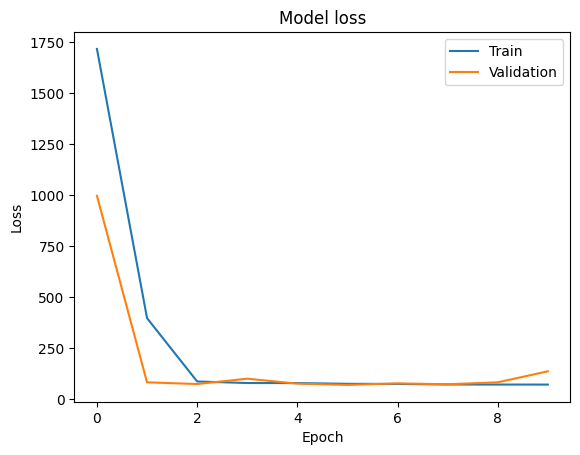

In [19]:
History_plot(h_lstm)

8/8 [==============================] - 0s 3ms/step


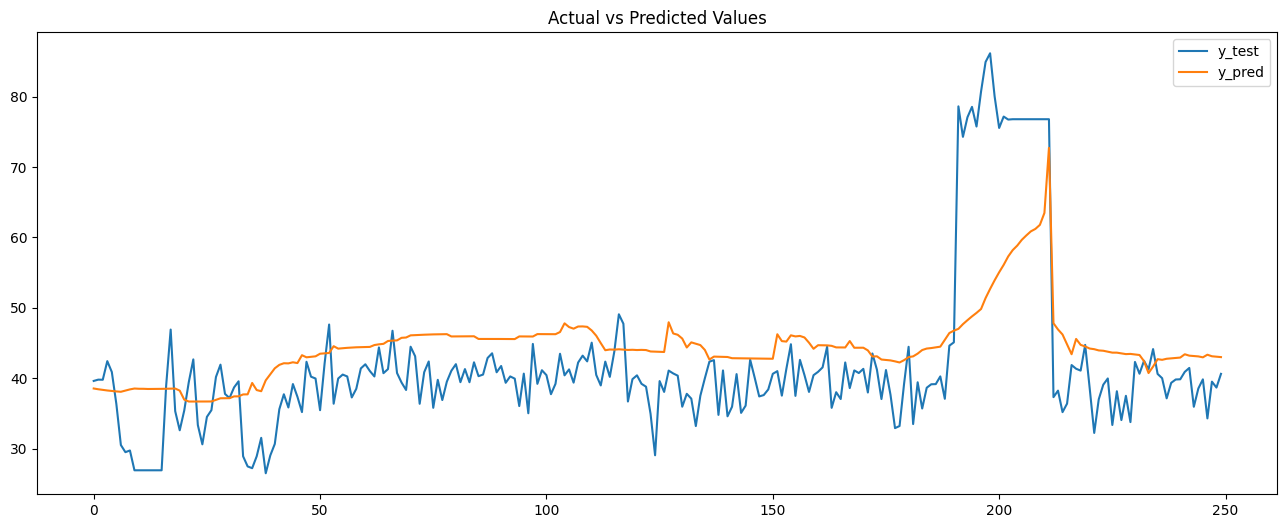

In [27]:
pred_vs_act(m_lstm,X_test_BIS,y_test_BIS,len = 250,mode = "lstm")

## FNN

In [11]:
m_ffnn, h_fnn = call_fnn(X_train_BIS,y_train_BIS,bs=32,epch=10)

Epoch 1/10
477/477 [==============================] - 4s 5ms/step - loss: 1719.9628 - mae: 39.7781 - val_loss: 895.1096 - val_mae: 28.7068
Epoch 2/10
477/477 [==============================] - 2s 5ms/step - loss: 406.3481 - mae: 17.0141 - val_loss: 139.7486 - val_mae: 8.9343
Epoch 3/10
477/477 [==============================] - 3s 6ms/step - loss: 88.4981 - mae: 7.2228 - val_loss: 96.9691 - val_mae: 7.7201
Epoch 4/10
477/477 [==============================] - 3s 5ms/step - loss: 80.9830 - mae: 6.9484 - val_loss: 63.1903 - val_mae: 6.1337
Epoch 5/10
477/477 [==============================] - 2s 5ms/step - loss: 80.1620 - mae: 6.9217 - val_loss: 122.1010 - val_mae: 9.0930
Epoch 6/10
477/477 [==============================] - 2s 5ms/step - loss: 79.6486 - mae: 6.8846 - val_loss: 71.7094 - val_mae: 6.2668
Epoch 7/10
477/477 [==============================] - 2s 5ms/step - loss: 78.3712 - mae: 6.8398 - val_loss: 105.4512 - val_mae: 8.6887
Epoch 8/10
477/477 [==============================] 

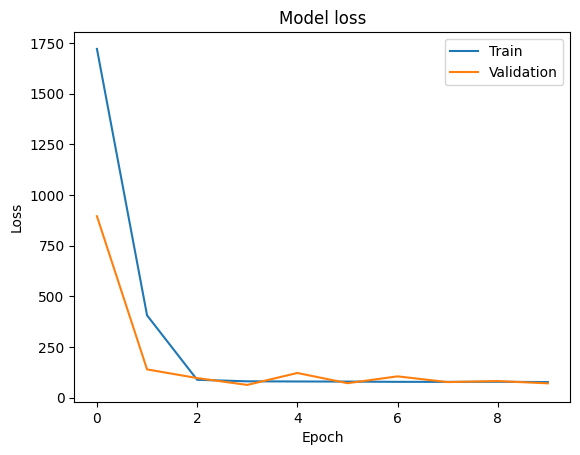

In [20]:
History_plot(h_fnn)

8/8 [==============================] - 0s 3ms/step


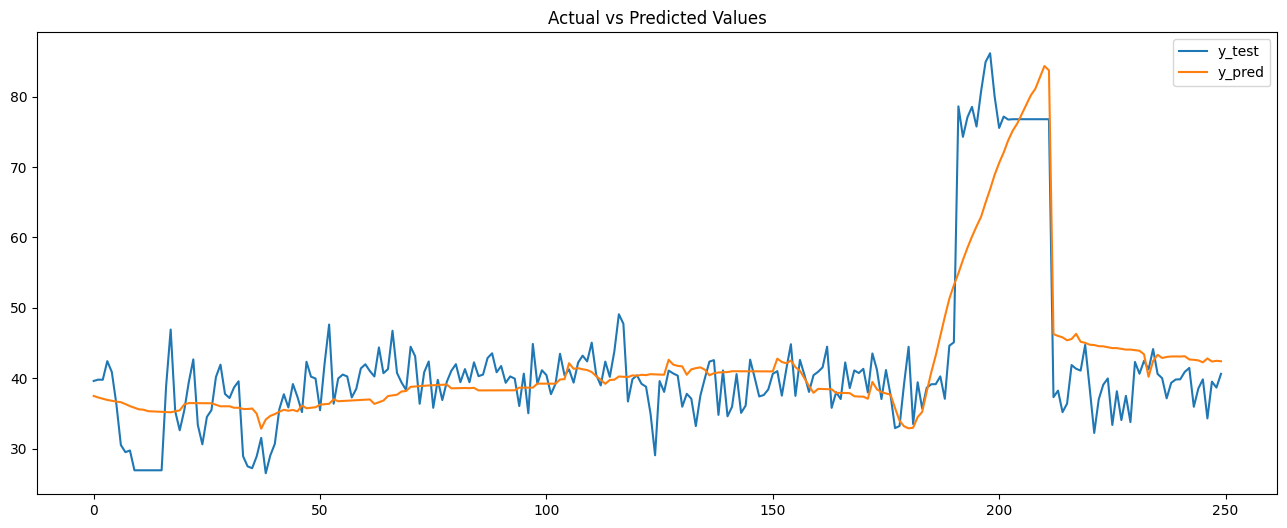

In [29]:
pred_vs_act(m_ffnn,X_test_BIS,y_test_BIS,len = 250,mode = "NaN")

## CNN

In [13]:
m_cnn, h_cnn = call_cnn(X_train_BIS,y_train_BIS,bs=32,epch=10)

Epoch 1/10
477/477 [==============================] - 4s 4ms/step - loss: 168.8364 - mae: 9.9524 - val_loss: 91.7370 - val_mae: 7.2492
Epoch 2/10
477/477 [==============================] - 2s 4ms/step - loss: 119.2754 - mae: 8.7709 - val_loss: 79.4899 - val_mae: 6.8680
Epoch 3/10
477/477 [==============================] - 2s 4ms/step - loss: 106.9042 - mae: 8.2514 - val_loss: 75.9108 - val_mae: 6.7732
Epoch 4/10
477/477 [==============================] - 2s 5ms/step - loss: 101.1703 - mae: 7.9669 - val_loss: 68.9215 - val_mae: 6.2541
Epoch 5/10
477/477 [==============================] - 2s 4ms/step - loss: 95.7894 - mae: 7.7049 - val_loss: 66.4245 - val_mae: 6.2150
Epoch 6/10
477/477 [==============================] - 2s 4ms/step - loss: 95.3896 - mae: 7.6755 - val_loss: 68.1184 - val_mae: 6.0673
Epoch 7/10
477/477 [==============================] - 2s 4ms/step - loss: 91.7934 - mae: 7.5152 - val_loss: 70.3055 - val_mae: 6.1983
Epoch 8/10
477/477 [==============================] - 2s 4

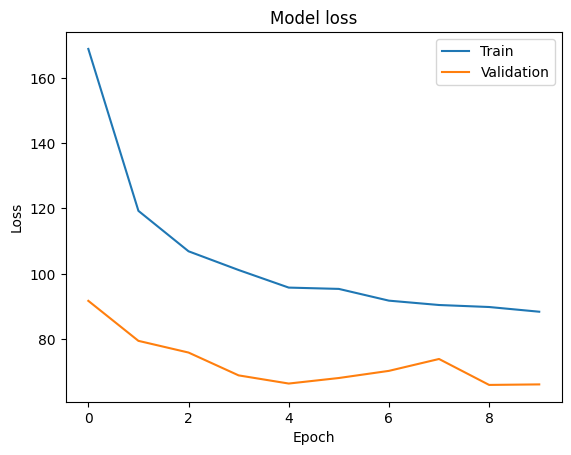

In [21]:
History_plot(h_cnn)

8/8 [==============================] - 0s 10ms/step


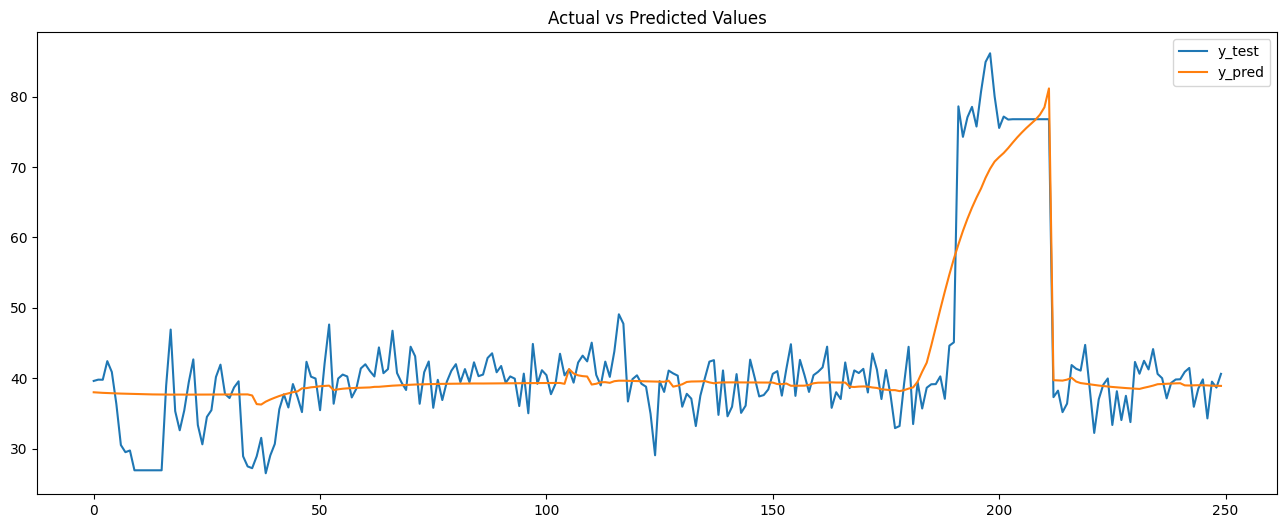

In [30]:
pred_vs_act(m_cnn,X_test_BIS,y_test_BIS,len = 250,mode = "NaN")

## GRN

In [16]:
m_grn, h_grn =call_GRN(X_train_BIS,y_train_BIS,bs=32,epch=10)

Epoch 1/10
477/477 [==============================] - 12s 12ms/step - loss: 333.3991 - mae: 12.2912 - val_loss: 161.4599 - val_mae: 10.0106
Epoch 2/10
477/477 [==============================] - 6s 13ms/step - loss: 77.4347 - mae: 6.7500 - val_loss: 92.1036 - val_mae: 7.3632
Epoch 3/10
477/477 [==============================] - 5s 11ms/step - loss: 72.2736 - mae: 6.4782 - val_loss: 83.5266 - val_mae: 7.1014
Epoch 4/10
477/477 [==============================] - 6s 13ms/step - loss: 69.0234 - mae: 6.3434 - val_loss: 107.6636 - val_mae: 8.4396
Epoch 5/10
477/477 [==============================] - 5s 11ms/step - loss: 64.9538 - mae: 6.1590 - val_loss: 88.6949 - val_mae: 7.0762
Epoch 6/10
477/477 [==============================] - 6s 13ms/step - loss: 63.7700 - mae: 6.0933 - val_loss: 72.0733 - val_mae: 6.2575
Epoch 7/10
477/477 [==============================] - 5s 11ms/step - loss: 60.4214 - mae: 5.9258 - val_loss: 108.8742 - val_mae: 7.6346
Epoch 8/10
477/477 [============================

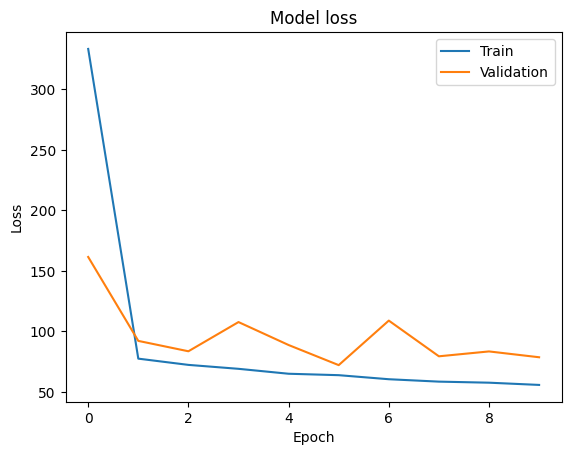

In [22]:
History_plot(h_grn)

8/8 [==============================] - 0s 3ms/step


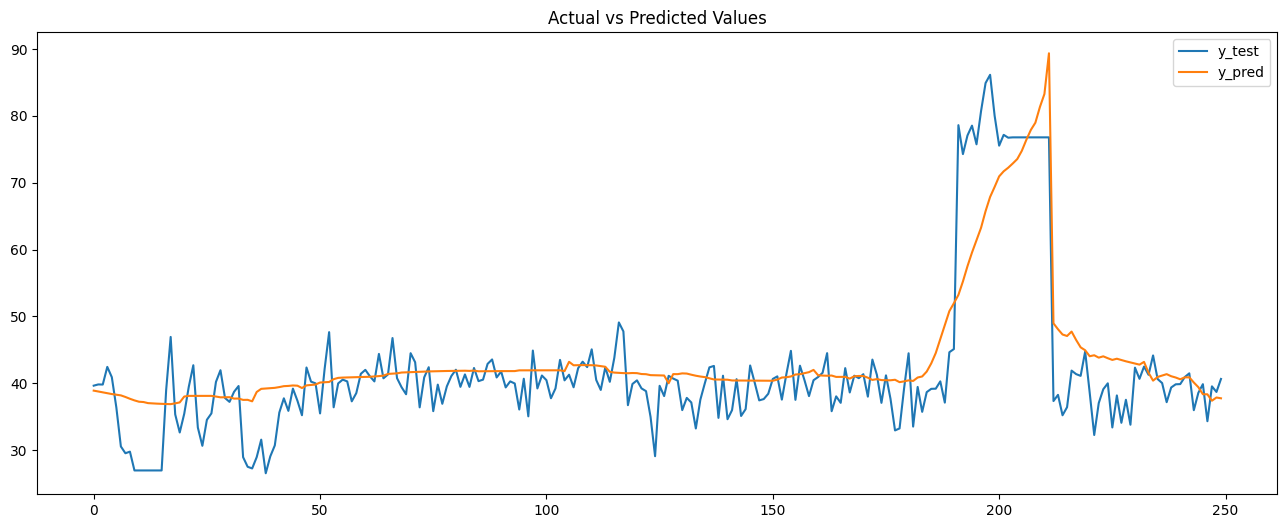

In [31]:
pred_vs_act(m_grn,X_test_BIS,y_test_BIS,len = 250,mode = "NaN")

In [36]:
m_resnet, h_resnet = call_resnet(X_train_BIS,y_train_BIS,bs=32,epch=10)

Epoch 1/10
477/477 [==============================] - 13s 14ms/step - loss: 296.5881 - mae: 11.6462 - val_loss: 107.7701 - val_mae: 8.1812
Epoch 2/10
477/477 [==============================] - 5s 11ms/step - loss: 81.8968 - mae: 6.8995 - val_loss: 86.3047 - val_mae: 7.2797
Epoch 3/10
477/477 [==============================] - 6s 13ms/step - loss: 73.8028 - mae: 6.5600 - val_loss: 124.5270 - val_mae: 7.9553
Epoch 4/10
477/477 [==============================] - 5s 11ms/step - loss: 69.7641 - mae: 6.3613 - val_loss: 90.5791 - val_mae: 7.2458
Epoch 5/10
477/477 [==============================] - 7s 14ms/step - loss: 66.6092 - mae: 6.1717 - val_loss: 74.0038 - val_mae: 6.5268
Epoch 6/10
477/477 [==============================] - 5s 11ms/step - loss: 62.7821 - mae: 5.9985 - val_loss: 97.1813 - val_mae: 7.4057
Epoch 7/10
477/477 [==============================] - 6s 12ms/step - loss: 62.4186 - mae: 5.9863 - val_loss: 126.0154 - val_mae: 9.0734
Epoch 8/10
477/477 [=============================

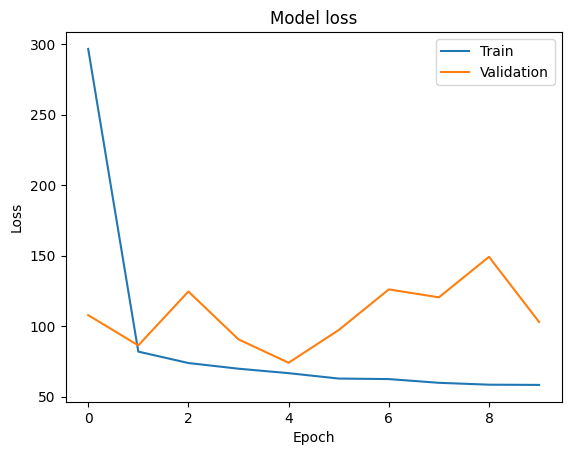

In [37]:
History_plot(h_resnet)

8/8 [==============================] - 0s 3ms/step


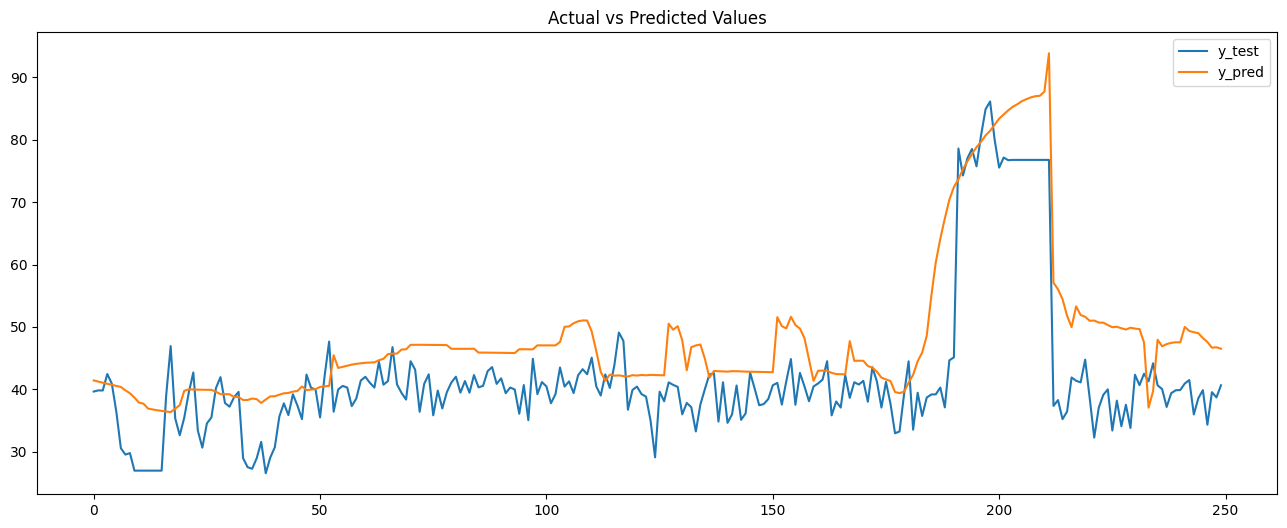

In [38]:
pred_vs_act(m_resnet,X_test_BIS,y_test_BIS,len = 250,mode = "NaN")

In [45]:
X_test_BIS = Patients_test_BIS[X_col]
y_test_BIS = Patients_test_BIS['BIS']

X_test_BIS = X_test_BIS.to_numpy()
y_test_BIS = y_test_BIS.to_numpy()

8/8 [==============================] - 0s 3ms/step


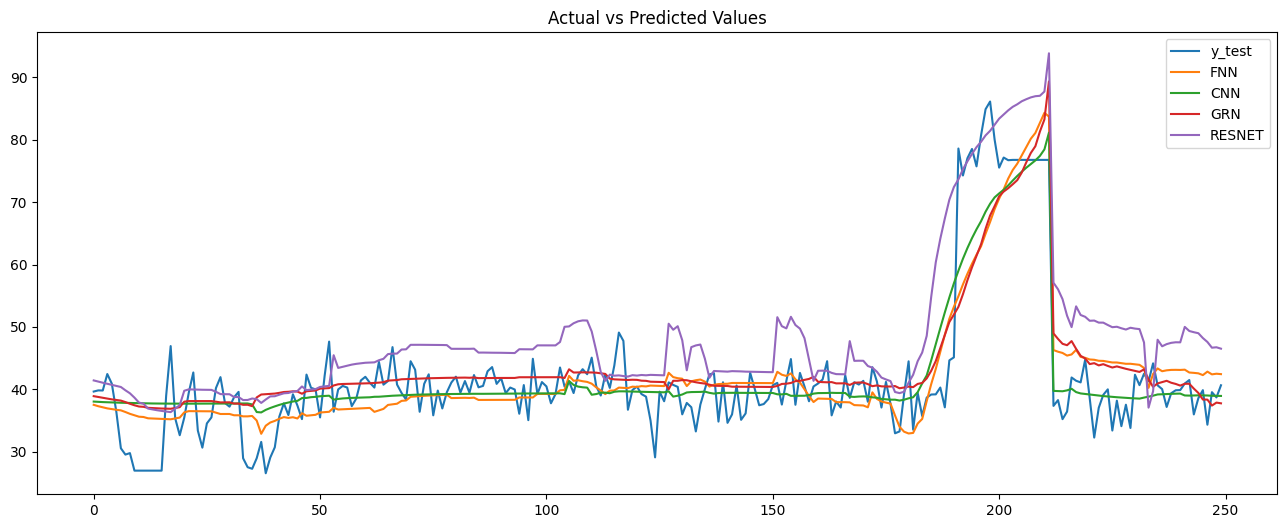

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras


# Make predictions on the test set

len = 250
ffnn_pred = m_ffnn.predict(X_test_BIS[:len])
cnn_pred  = m_cnn.predict(X_test_BIS[:len])
grn_pred  = m_grn.predict(X_test_BIS[:len])
resnet_pred = m_resnet.predict(X_test_BIS[:len])



plt.figure(figsize=(16, 6))
# Plot actual vs predicted values
plt.plot(y_test_BIS[:len])
plt.plot(ffnn_pred)
plt.plot(cnn_pred)
plt.plot(grn_pred)
plt.plot(resnet_pred)

plt.title("Actual vs Predicted Values")
plt.legend(['y_test', 'FNN','CNN','GRN','RESNET'], loc='upper right')
plt.show()